In [226]:
import pandas as pd
import matplotlib.pyplot as plt
from kp import kp_indices
from goes import goes16_magnetometer

In [246]:
kp = kp_indices()
max_kp_day = kp.groupby(['year', 'month', 'day']).max()['Kp'].reset_index()
no_geo_activity = max_kp_day[max_kp_day.Kp <= 1]

In [248]:
no_geo_activity[no_geo_activity.year >= 2018]

,year,month,day,Kp
31414,2018,1,3,1.000
31418,2018,1,7,1.000
31422,2018,1,11,1.000
31428,2018,1,17,0.667
31429,2018,1,18,0.333
...,...,...,...,...
33679,2024,3,17,0.333
33717,2024,4,24,1.000
33718,2024,4,25,0.667
33767,2024,6,13,1.000


In [243]:
no_activity_early_may = no_geo_activity[(no_geo_activity.month == 5 ) & (no_geo_activity.day <= 15)]
no_activity_early_may = no_activity_early_may[no_activity_early_may.year >= 2018]
# no_activity_early_may = no_activity_early_may.groupby('year').min('Kp').reset_index()
no_activity_early_may

,year,month,day,Kp
31532,2018,5,1,1.000
31534,2018,5,3,1.333
31535,2018,5,4,1.333
31546,2018,5,15,1.333
31901,2019,5,5,1.333
31904,2019,5,8,1.000
32269,2020,5,7,1.333
32270,2020,5,8,1.333
32271,2020,5,9,0.667
32275,2020,5,13,1.333


In [244]:
no_activity_early_oct = no_geo_activity[(no_geo_activity.month == 10) & (no_geo_activity.day <= 15)]
no_activity_early_oct = no_activity_early_oct[no_activity_early_oct.year >= 2018]
# no_activity_early_oct = no_activity_early_oct.groupby('year').min('Kp').reset_index()
no_activity_early_oct

,year,month,day,Kp
32062,2019,10,13,0.667
32423,2020,10,8,0.667
32424,2020,10,9,0.333
32425,2020,10,10,0.667
32426,2020,10,11,1.333
32427,2020,10,12,1.333
32428,2020,10,13,1.000
32429,2020,10,14,0.000
32430,2020,10,15,1.000
32787,2021,10,7,1.333


In [125]:
def mean_mags(dts: list[pd.Timestamp]) -> pd.DataFrame:
    mag_dfs = []
    for ts in dts:
        mag_df = goes16_magnetometer(ts)
        da = mag_df.sel(coordinate=1).drop_vars('coordinate')
        df = da.to_dataframe()
    
        df['hour'] = df.index.hour
        df['minute'] = df.index.minute
        df = df.reset_index()[['b_epn', 'hour', 'minute']]
        df.set_index(['hour', 'minute'], inplace=True)
        mag_dfs.append(df)
        
    concats = pd.concat(mag_dfs, axis=1)
    return concats.mean(axis=1), concats.std(axis=1)

In [187]:
dts_may = pd.to_datetime(no_activity_early_may[['year', 'month', 'day']])
dts_oct = pd.to_datetime(no_activity_early_oct[['year', 'month', 'day']])
mag_zero_may, _ = mean_mags(dts_may)
mag_zero_oct, _ = mean_mags(dts_oct)

In [212]:
mag_zero_may_values = mag_zero_may.reset_index()
mag_zero_may_values.rename(columns={0: 'B'}, inplace=True)
mag_zero_may_values = mag_zero_may_values.B

mag_zero_oct_values = mag_zero_oct.reset_index()
mag_zero_oct_values.rename(columns={0: 'B'}, inplace=True)
mag_zero_oct_values = mag_zero_oct_values.B

In [213]:
mag_zero_may_values

0       91.571693
1       91.468979
2       91.500999
3       91.494553
4       91.428360
          ...    
1435    94.585213
1436    94.531204
1437    94.461960
1438    94.441101
1439    94.396835
Name: B, Length: 1440, dtype: float32

In [214]:
mag_zero_oct_values

0       90.574875
1       90.447075
2       90.371193
3       90.271957
4       90.204590
          ...    
1435    92.008728
1436    91.955879
1437    91.972061
1438    91.870903
1439    91.816483
Name: B, Length: 1440, dtype: float32

<Axes: >

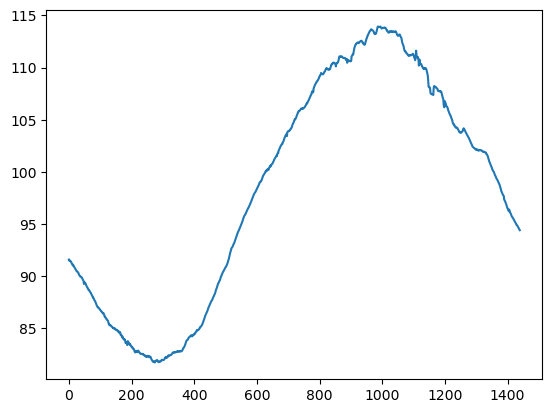

In [215]:
mag_zero_may_values.plot()

<Axes: >

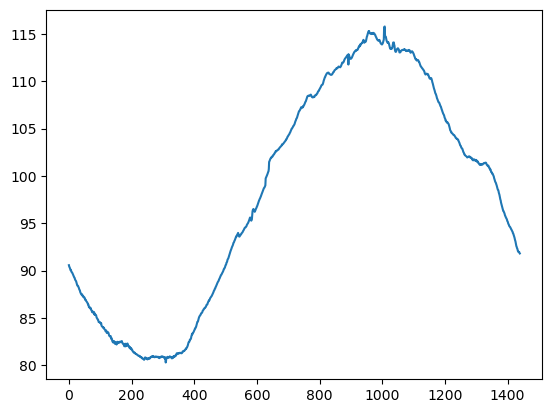

In [216]:
mag_zero_oct_values.plot()

In [237]:
may10_mag = goes16_magnetometer('2024-05-10')
may10_mag = may10_mag.sel(coordinate=1).drop_vars('coordinate').to_dataframe()
may10_mag

,b_epn
time,
2024-05-10 00:00:00,87.941010
2024-05-10 00:01:00,87.468361
2024-05-10 00:02:00,87.152924
2024-05-10 00:03:00,86.751305
2024-05-10 00:04:00,86.818207
...,...
2024-05-10 23:55:00,84.592308
2024-05-10 23:56:00,76.143196
2024-05-10 23:57:00,73.347282


<Axes: >

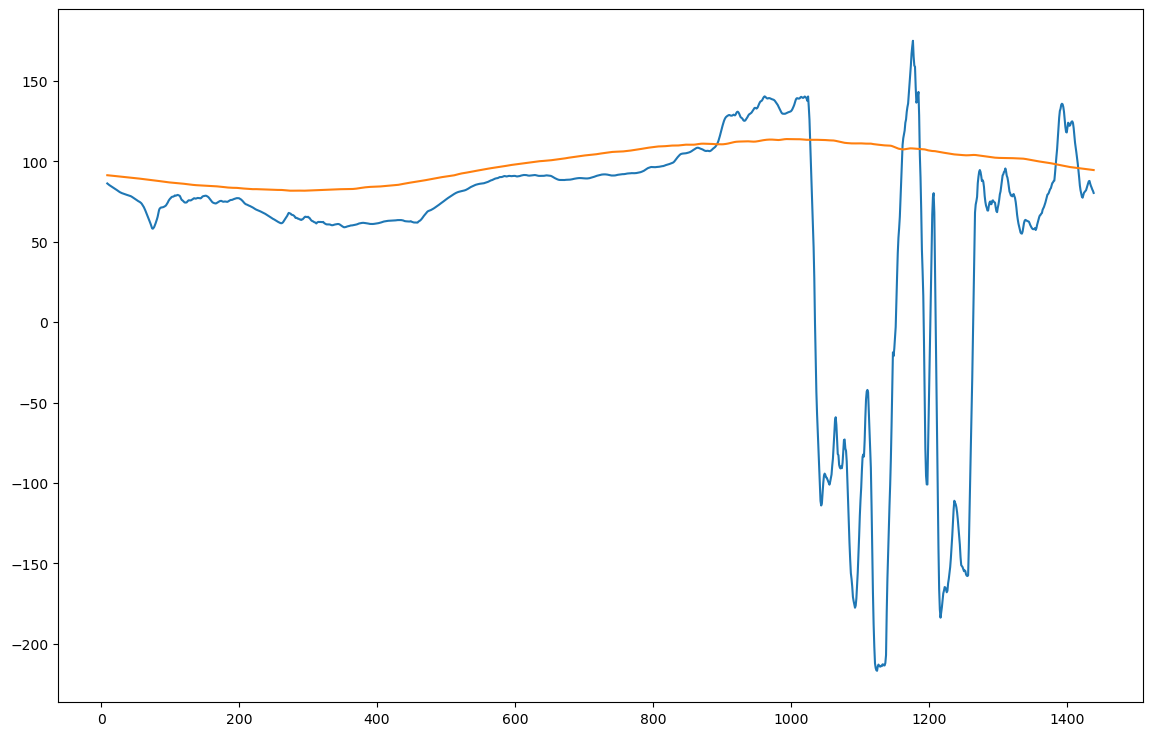

In [239]:
rolling_period = 10
fig = plt.figure(figsize=(14, 9))
may10_mag.reset_index().b_epn.rolling(rolling_period).mean().plot()
mag_zero_may_values.rolling(rolling_period).mean().plot()

In [240]:
oct10_mag = goes16_magnetometer('2024-10-10')
oct10_mag = oct10_mag.sel(coordinate=1).drop_vars('coordinate').to_dataframe()
oct10_mag

,b_epn
time,
2024-10-10 00:00:00,85.655739
2024-10-10 00:01:00,85.509468
2024-10-10 00:02:00,85.471092
2024-10-10 00:03:00,85.553581
2024-10-10 00:04:00,85.491127
...,...
2024-10-10 23:55:00,97.433533
2024-10-10 23:56:00,101.277023
2024-10-10 23:57:00,94.740807


<Axes: >

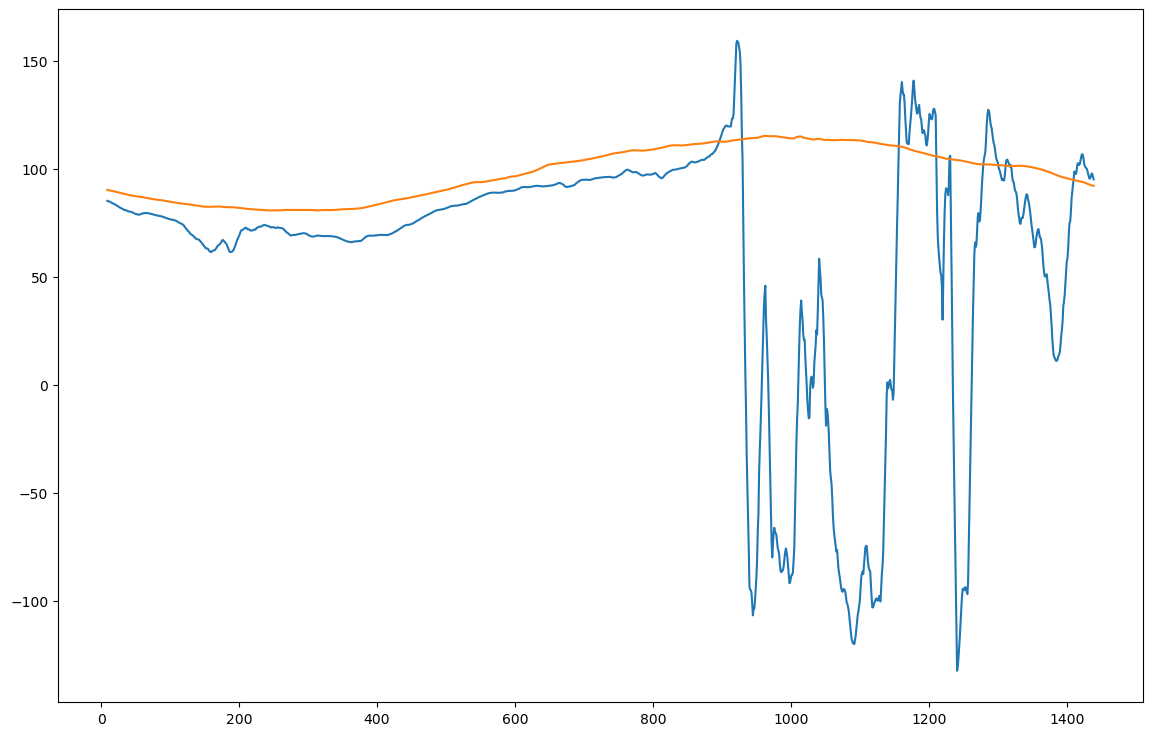

In [241]:
rolling_period = 10
fig = plt.figure(figsize=(14, 9))
oct10_mag.reset_index().b_epn.rolling(rolling_period).mean().plot()
mag_zero_oct_values.rolling(rolling_period).mean().plot()